In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# Color formatting
cmap = 'Dark2'
color='#4e6c50'

In [3]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
df.shape

(2240, 29)

# Preprocessing

In [4]:
# clean dataset
df = (df
    .fillna(df.median(numeric_only=True))
    .drop(['ID','Dt_Customer', 'Z_CostContact','Z_Revenue'], axis=1))

# list all categorical columns
categorical_cols = ['Education', 'Marital_Status']

## Tests

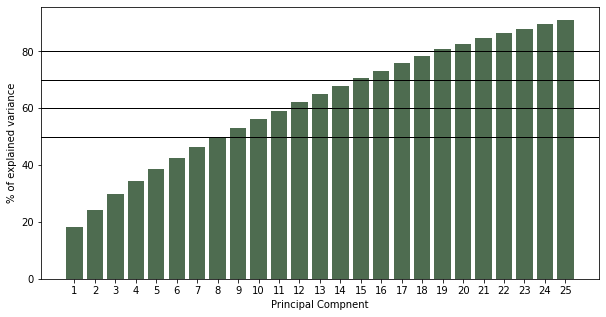

In [5]:
scaler = StandardScaler()
X = pd.get_dummies(df)
X = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(X)
df[['PC1','PC2','PC3']] = principalComponents[:,:3]

# Plot the explained variances
features = range(1, pca.n_components_+1)
plt.figure(figsize=(10,5))
plt.bar(features, (pca.explained_variance_ratio_.cumsum()*100).round(2), color=color)
for y in [50, 60, 70, 80]:
    plt.axhline(y=y, linewidth=1, color='k')
plt.xlabel('Principal Compnent')
plt.ylabel('% of explained variance')
plt.xticks(features);

## Final preprocessing pipeline

In [6]:
# encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_cols),    
    ],
    remainder='passthrough'
)

# scale all columns and apply a PCA
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components=2)) #12
])

X = pipeline.fit_transform(df)


# Clustering

## K-means

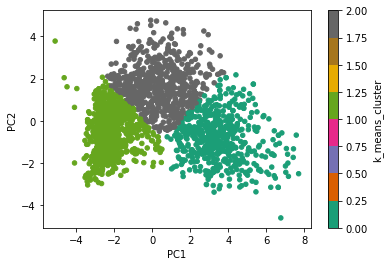

In [7]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(
    n_clusters=k,
    init='k-means++',
    n_init=10,
    max_iter=500,
    tol=0.00001,
    algorithm='elkan',
    random_state=0,
).fit(X)

df['k_means_cluster'] = kmeans.predict(X)

fig, ax = plt.subplots()
df.plot.scatter(x='PC1', y='PC2', c = 'k_means_cluster', cmap=cmap, ax=ax);

## DBSCAN

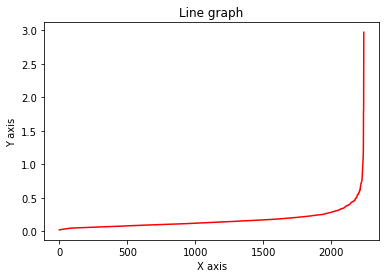

In [8]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()
knn.fit(X)
distances, indices = knn.kneighbors(X, return_distance=True)
kdistances = distances[...,3]
kdistances.sort()

# data to be plotted
k = np.arange(1, len(kdistances)+1)
y = kdistances

# plotting
plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(k, y, color ="red");

dbscan_cluster
-1      67
 0    2143
 1       9
 2       6
 3       5
 4       4
 5       6
dtype: int64


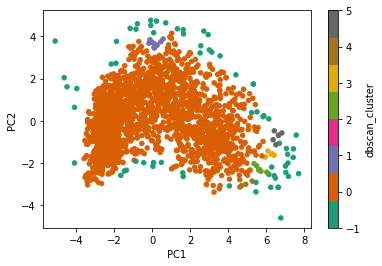

In [9]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=0.4,
    min_samples=4,
    metric='euclidean',
    #metric_params={'V':np.cov(X.T)} #can be used of mahalanobis distance
).fit(X)

df['dbscan_cluster'] = dbscan.labels_

print(df.groupby(by='dbscan_cluster').size())
fig, ax = plt.subplots()
df.plot.scatter(x='PC1', y='PC2', c = 'dbscan_cluster', cmap=cmap, ax=ax);

## Agglomerative clustering

agglomerative_cluster
0    1249
1     480
2     511
dtype: int64


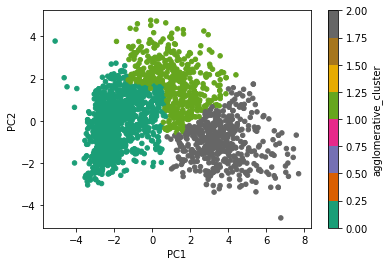

In [10]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(
    n_clusters = 3,
    affinity = 'euclidean',
    linkage = 'ward'
).fit(X)

df['agglomerative_cluster'] = agglomerative.labels_

print(df.groupby(by='agglomerative_cluster').size())

fig, ax = plt.subplots()
df.plot.scatter(x='PC1', y='PC2', c = 'agglomerative_cluster', cmap=cmap, ax=ax);

## GMM

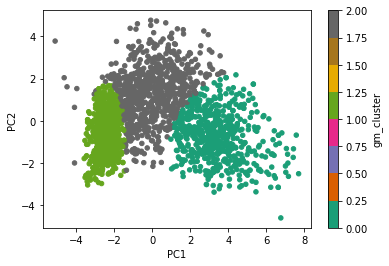

In [11]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(
    n_components=3,
    covariance_type ='full',
    random_state=0
).fit(X)

df['gm_cluster'] = gm.predict(X)
df.groupby(by='gm_cluster').size()

fig, ax = plt.subplots()
df.plot.scatter(x='PC1', y='PC2', c = 'gm_cluster', cmap=cmap, ax=ax);

In [12]:
gm.predict_proba(X)

array([[9.98005452e-01, 5.53517727e-47, 1.99454805e-03],
       [1.22140328e-04, 9.51402695e-01, 4.84751649e-02],
       [7.59795954e-01, 1.68746847e-19, 2.40204046e-01],
       ...,
       [5.86353531e-01, 8.25291645e-18, 4.13646469e-01],
       [2.59585411e-01, 6.72247352e-19, 7.40414589e-01],
       [3.92375487e-03, 2.71207731e-01, 7.24868514e-01]])

# Scores

In [13]:
algorithms = ['k_means','dbscan', 'agglomerative', 'gm']
scores = {c: round(silhouette_score(X, df[c+'_cluster']),3) for c in algorithms}
scores

{'k_means': 0.482, 'dbscan': 0.042, 'agglomerative': 0.458, 'gm': 0.432}

In [14]:
df.groupby('k_means_cluster').median(numeric_only=True)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,PC1,PC2,PC3,dbscan_cluster,agglomerative_cluster,gm_cluster
k_means_cluster,,,,,,,,,,,,,,,,,,,,,
0,1970.0,76045.0,0.0,0.0,51.0,546.0,59.0,417.0,91.0,58.0,...,0.0,0.0,0.0,0.0,3.332703,-0.799945,-0.514144,0.0,2.0,0.0
1,1973.0,34421.0,1.0,0.0,49.0,20.0,3.0,15.0,4.0,3.0,...,0.0,0.0,0.0,0.0,-2.387975,-0.626688,0.087452,0.0,0.0,1.0
2,1963.0,57958.0,0.0,1.0,49.0,392.5,10.0,103.0,15.0,10.0,...,0.0,0.0,0.0,0.0,0.341966,1.588933,-0.456246,0.0,1.0,2.0


In [15]:
df.groupby('agglomerative_cluster').median(numeric_only=True)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,PC1,PC2,PC3,k_means_cluster,dbscan_cluster,gm_cluster
agglomerative_cluster,,,,,,,,,,,,,,,,,,,,,
0,1972.0,37284.0,1.0,0.0,48.0,30.0,3.0,18.0,4.0,3.0,...,0.0,0.0,0.0,0.0,-2.209948,-0.283786,0.012459,1.0,0.0,1.0
1,1963.0,62619.0,0.0,1.0,52.0,526.0,17.0,152.0,23.0,17.0,...,0.0,0.0,0.0,0.0,1.217902,1.826746,-0.532164,2.0,0.0,2.0
2,1970.0,76982.0,0.0,0.0,51.0,536.0,60.0,430.0,95.0,61.0,...,0.0,0.0,0.0,0.0,3.446200,-0.985127,-0.448408,0.0,0.0,0.0


In [16]:
df.groupby('dbscan_cluster').median(numeric_only=True)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,PC1,PC2,PC3,k_means_cluster,agglomerative_cluster,gm_cluster
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,
-1,1972.0,71670.0,0.0,0.0,47.0,736.0,29.0,128.0,50.0,25.0,...,0.0,0.0,0.0,0.0,2.942115,0.096305,1.114773,1.0,1.0,1.0
0,1970.0,50898.0,0.0,0.0,49.0,163.0,8.0,63.0,12.0,8.0,...,0.0,0.0,0.0,0.0,-0.814526,-0.141309,-0.181595,1.0,0.0,1.0
1,1955.0,58607.0,0.0,1.0,62.0,489.0,5.0,70.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.124744,3.673185,0.922230,2.0,1.0,2.0
2,1967.5,81697.0,0.0,0.0,40.5,663.5,117.0,586.0,168.5,144.0,...,0.5,0.0,0.0,0.5,5.618791,-2.308872,0.912581,0.0,2.0,0.0
3,1961.0,83512.0,0.0,0.0,32.0,736.0,163.0,818.0,192.0,138.0,...,1.0,0.0,0.0,1.0,6.267106,-1.567784,1.372098,0.0,2.0,0.0
4,1972.5,80695.0,0.0,0.0,42.0,424.0,132.5,674.5,162.0,119.0,...,0.5,0.0,0.0,0.0,4.807026,-3.029670,-0.209853,0.0,2.0,0.0
5,1954.0,88520.5,0.0,0.0,62.0,1047.5,33.5,721.5,160.0,98.0,...,1.0,0.0,0.0,1.0,6.568291,-0.678255,3.338557,0.0,2.0,0.0


In [17]:
df.groupby('gm_cluster').median(numeric_only=True).round(2)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,PC1,PC2,PC3,k_means_cluster,dbscan_cluster,agglomerative_cluster
gm_cluster,,,,,,,,,,,,,,,,,,,,,
0,1970.0,75484.0,0.0,0.0,52.0,547.0,54.0,405.0,89.0,58.0,...,0.0,0.0,0.0,0.0,3.25,-0.69,-0.56,0.0,0.0,2.0
1,1974.0,32313.0,1.0,0.0,48.0,15.0,2.0,12.0,3.0,2.0,...,0.0,0.0,0.0,0.0,-2.50,-0.73,0.14,1.0,0.0,0.0
2,1965.0,55249.5,0.0,1.0,50.0,284.0,9.0,84.0,13.0,9.0,...,0.0,0.0,0.0,0.0,-0.15,1.36,-0.44,2.0,0.0,0.0
